# Лабораторна робота №1 — Регресійні експерименти

**Студентка:** Olena Mykhailovska  
**Група:** CS-31  
**STUDENT_NO:** 13

**Тема:** Експерименти з регресією: (I) штучно згенеровані дані — інтуїція; (II) реальний датасет — прогноз місячного доходу ресторану.

**Мета роботи:** Розвинути інтуїцію щодо різних регресійних моделей на штучних даних та застосувати підхід до реального датасету з підготовкою, візуалізацією, підбором гіперпараметрів та оцінкою моделі.


In [2]:
# Імпорти та налаштування
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Моделі
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Для відтворюваності
STUDENT_NAME = 'Olena'
STUDENT_SURNAME = 'Mykhailovska'
GROUP = 'CS-31'
STUDENT_NO = 13
RANDOM_STATE = STUDENT_NO

# Параметри візуалізації
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style='whitegrid')


# Частина I — Експерименти на штучно згенерованих даних

Цілі:
- Згенерувати лінійні та нелінійні дані з шумом і викидами.
- Ручне налаштування простого лінійного моделлю (зміна коефіцієнтів) та спостереження метрик.
- Порівняти результати зі стандартними моделями sklearn.
- Розширити генератор для складніших функцій (sin, cos, поліном).


In [3]:
# --- Генератор регресійних даних (взято та розширено з умови) ---
def generate_regression_data(n_samples=200,
                             n_features=1,
                             mode='linear',
                             noise=2.0,
                             n_outliers=5,
                             random_seed=RANDOM_STATE,
                             return_coef=False):
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features) * 10 - 5
    true_intercept = 0
    true_weights = np.zeros(n_features)
    if mode == 'linear':
        true_intercept = np.random.uniform(-3, 3)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = np.dot(X, true_weights) + true_intercept
    elif mode == 'nonlinear':
        true_intercept = np.random.uniform(-15, 15)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = true_weights[0] * 20 * np.sin(X[:, 0]*1.5) + true_intercept
        if n_features > 1:
            y_true += np.dot(X[:, 1:], true_weights[1:])
    elif mode == 'complex':
        # складна функція: поліном + sin + cos
        true_intercept = np.random.uniform(-10, 10)
        true_weights = np.random.uniform(-3, 3, size=n_features)
        y_true = true_intercept
        y_true += true_weights[0] * (X[:, 0]**2) * 0.5
        y_true += 10 * np.sin(X[:, 0]) 
        y_true += 5 * np.cos(X[:, 0] * 0.5)
        if n_features > 1:
            y_true += np.dot(X[:, 1:], true_weights[1:])
    else:
        raise ValueError('mode must be "linear", "nonlinear" or "complex"')
    y = y_true + np.random.normal(scale=noise, size=n_samples)
    if n_outliers > 0:
        outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
        outlier_offset = (np.random.rand(n_outliers) - 0.5) * 30 * (noise + 1)
        y[outlier_indices] += outlier_offset
    if return_coef:
        return X, y, {'weights': true_weights, 'intercept': true_intercept}
    return X, y

# --- Візуалізація для 1D та багатовимірного випадку ---
def plot_regression_model(X, y, weights=None, intercept=None, title='Regression'):
    X_ = X if X.ndim == 1 else X[:, 0]
    if X.ndim > 1:
        X_ = X[:, 0]
    plt.scatter(X_, y, alpha=0.7, edgecolor='k')
    if weights is not None and intercept is not None:
        x_line = np.linspace(X_.min(), X_.max(), 200)
        y_line = x_line * weights[0] + intercept
        plt.plot(x_line, y_line, color='crimson', linewidth=2)
        plt.title(title + f' — model: y = {weights[0]:.2f} x + {intercept:.2f}')
    else:
        plt.title(title)
    plt.xlabel('X (feature 0)')
    plt.ylabel('y (target)')
    plt.show()

def evaluate_regression_model(y_true, y_pred, print_results=True):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    if print_results:
        print('----- 📈 Evaluation -----')
        for k, v in metrics.items():
            print(f'{k}: {v:.4f}')
        print('------------------------')
    return metrics


## I.1 Ручна (manual) лінійна регресія

Покажемо як змінюються метрики при ручній підстановці коефіцієнтів для простого 1D випадку.


True generative coefficients (hidden): {'weights': array([-2.18078278]), 'intercept': -1.9058883395986774}

Manual model: {'weights': [-5], 'intercept': -20}
----- 📈 Evaluation -----
MAE: 18.2433
MSE: 460.3628
RMSE: 21.4561
R2: -2.8357
------------------------


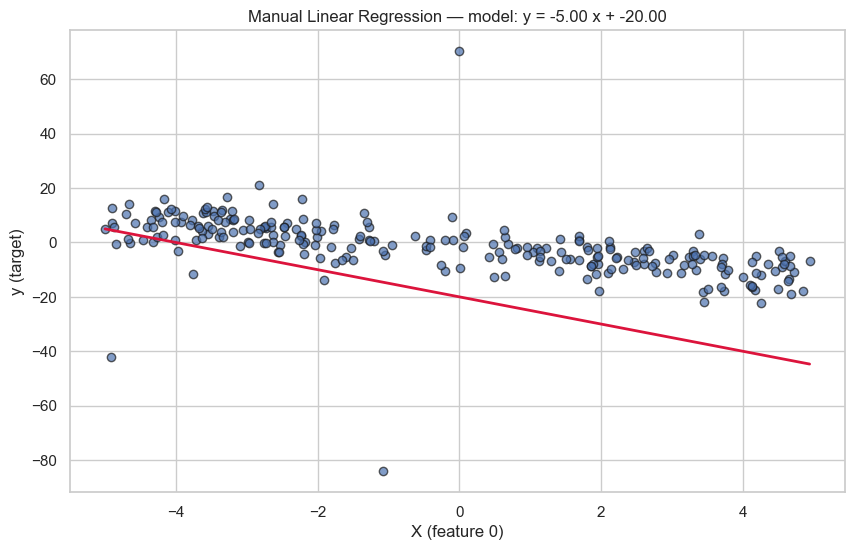


Manual model: {'weights': [0], 'intercept': np.float64(-1.450166049389318)}
----- 📈 Evaluation -----
MAE: 7.3247
MSE: 120.0201
RMSE: 10.9554
R2: 0.0000
------------------------


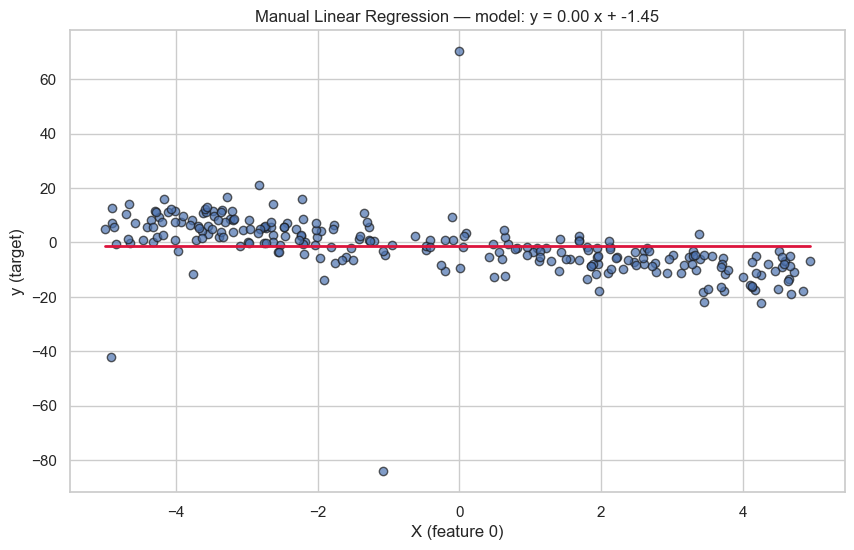


Manual model: {'weights': [np.float64(-2.1807827776675714)], 'intercept': -1.9058883395986774}
----- 📈 Evaluation -----
MAE: 4.7926
MSE: 85.7954
RMSE: 9.2626
R2: 0.2852
------------------------


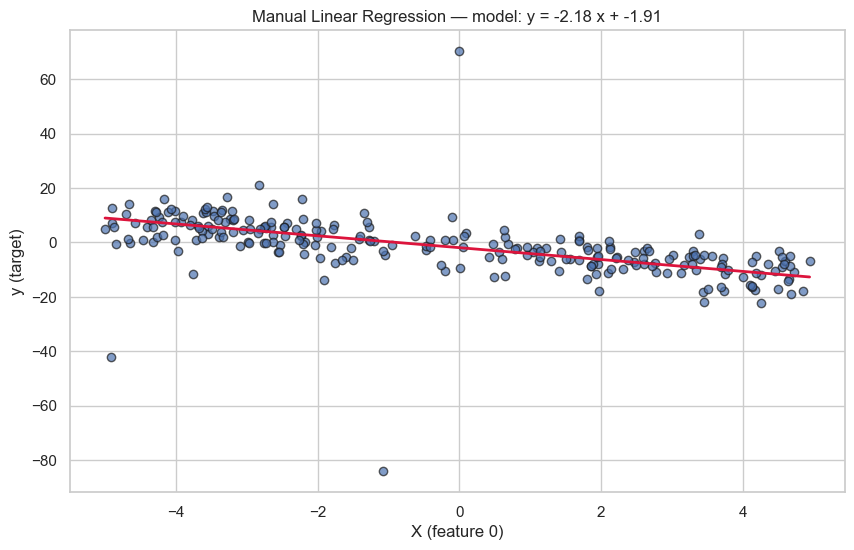

In [4]:
# Генеруємо лінійні дані
X_lin, y_lin, coeffs_lin = generate_regression_data(n_samples=250,
                                                   n_features=1,
                                                   mode='linear',
                                                   noise=5.0,
                                                   n_outliers=7,
                                                   random_seed=RANDOM_STATE,
                                                   return_coef=True)
print('True generative coefficients (hidden):', coeffs_lin)

# Перетворимо X в 1D для візуалізації
X_lin_1d = X_lin.flatten()

# Ручна модель: підберемо кілька варіантів коефіцієнтів
manual_models = [
    {'weights': [-5], 'intercept': -20},
    {'weights': [0], 'intercept': np.mean(y_lin)},
    {'weights': [coeffs_lin['weights'][0]], 'intercept': coeffs_lin['intercept']}
]

for m in manual_models:
    y_pred_manual = m['weights'][0] * X_lin_1d + m['intercept']
    print('\nManual model:', m)
    evaluate_regression_model(y_lin, y_pred_manual)
    plot_regression_model(X_lin_1d, y_lin, weights=m['weights'], intercept=m['intercept'],
                          title='Manual Linear Regression')


## I.2 Нелінійні дані та складні ручні функції

Згенеруємо нелінійні та 'complex' дані (sin+cos+поліном) та подивимось, наскільки лінійна модель підходить.


Manual on nonlinear:
----- 📈 Evaluation -----
MAE: 30.1063
MSE: 1270.5357
RMSE: 35.6446
R2: -6.7671
------------------------


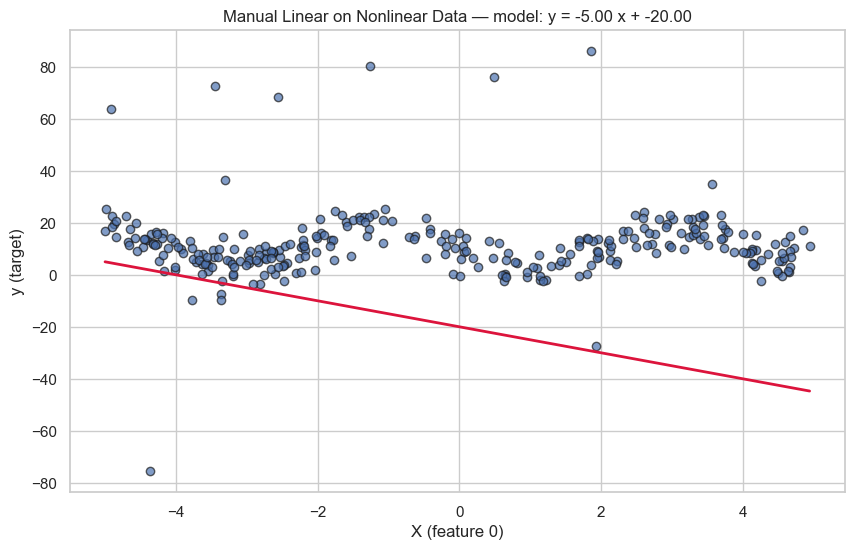

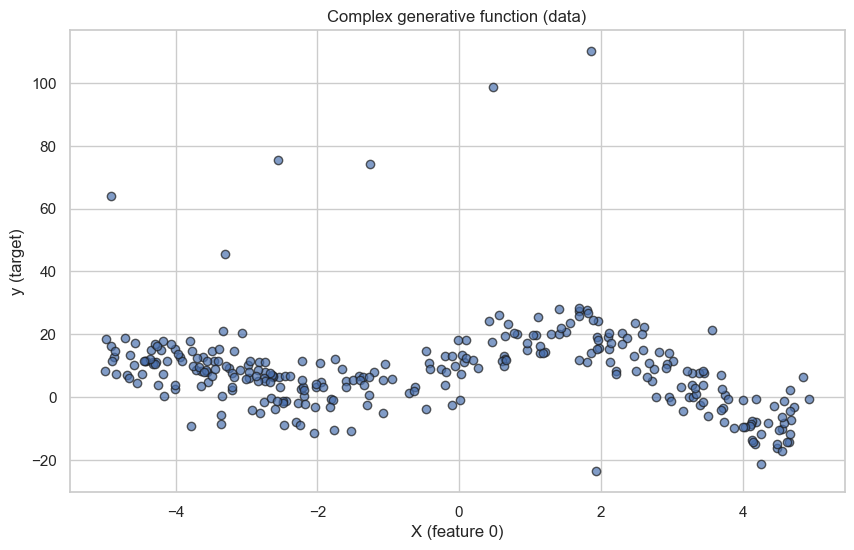

In [5]:
# Генеруємо нелінійні дані
X_nonlin, y_nonlin, coeffs_nonlin = generate_regression_data(n_samples=300,
                                                             n_features=1,
                                                             mode='nonlinear',
                                                             noise=5.0,
                                                             n_outliers=10,
                                                             random_seed=RANDOM_STATE,
                                                             return_coef=True)
X_nonlin_1d = X_nonlin.flatten()

# Спроба лінійної ручної моделі на нелінійних даних
manual = {'weights': [-5], 'intercept': -20}
y_pred_manual = manual['weights'][0] * X_nonlin_1d + manual['intercept']
print('Manual on nonlinear:')
evaluate_regression_model(y_nonlin, y_pred_manual)
plot_regression_model(X_nonlin_1d, y_nonlin, weights=manual['weights'], intercept=manual['intercept'],
                      title='Manual Linear on Nonlinear Data')

# Генеруємо complex data
X_c, y_c, coeffs_c = generate_regression_data(n_samples=300, n_features=1, mode='complex',
                                              noise=6.0, n_outliers=8, random_seed=RANDOM_STATE, return_coef=True)
plot_regression_model(X_c.flatten(), y_c, title='Complex generative function (data)')


## I.3 Тестування sklearn моделей на штучних даних

Перевіримо: Ridge, RandomForest, GradientBoosting — швидка підгонка і порівняння метрик.



Model: Ridge
----- 📈 Evaluation -----
MAE: 8.6347
MSE: 255.8710
RMSE: 15.9960
R2: -0.0203
------------------------


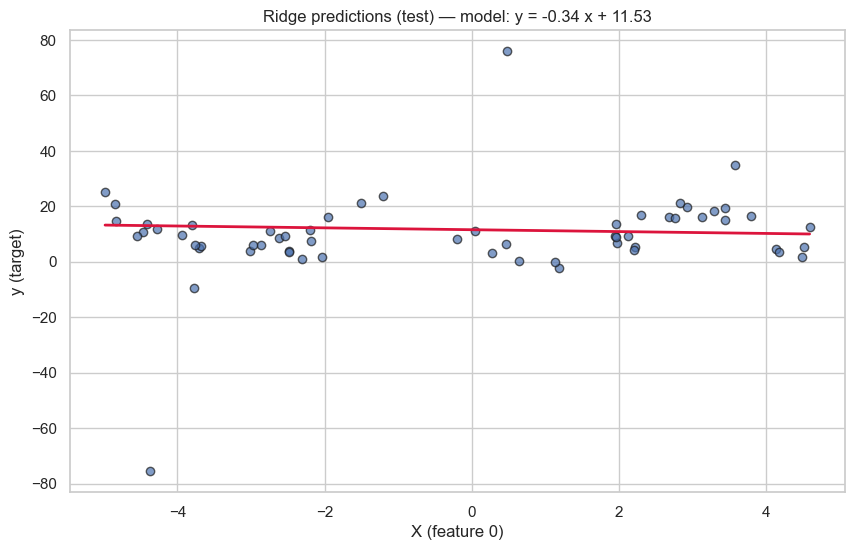


Model: RandomForest
----- 📈 Evaluation -----
MAE: 8.0404
MSE: 288.9707
RMSE: 16.9991
R2: -0.1523
------------------------


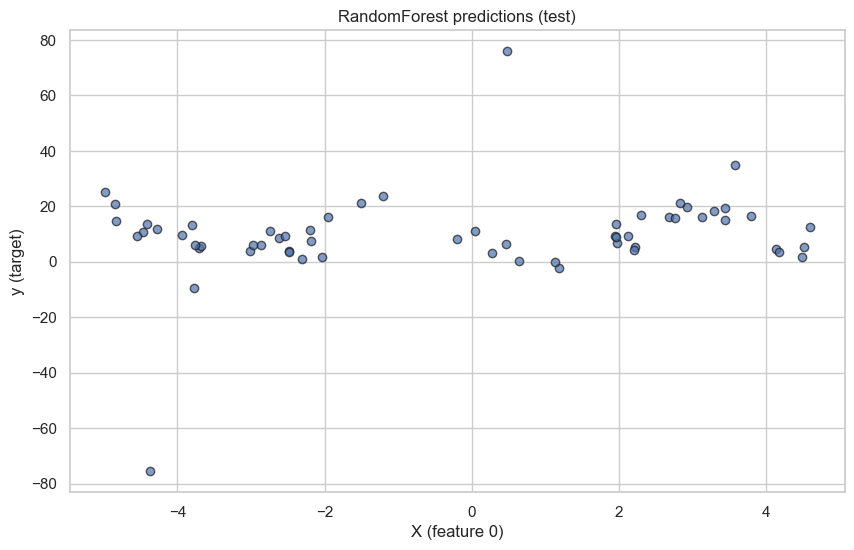


Model: GradientBoosting
----- 📈 Evaluation -----
MAE: 7.8581
MSE: 298.6013
RMSE: 17.2801
R2: -0.1907
------------------------


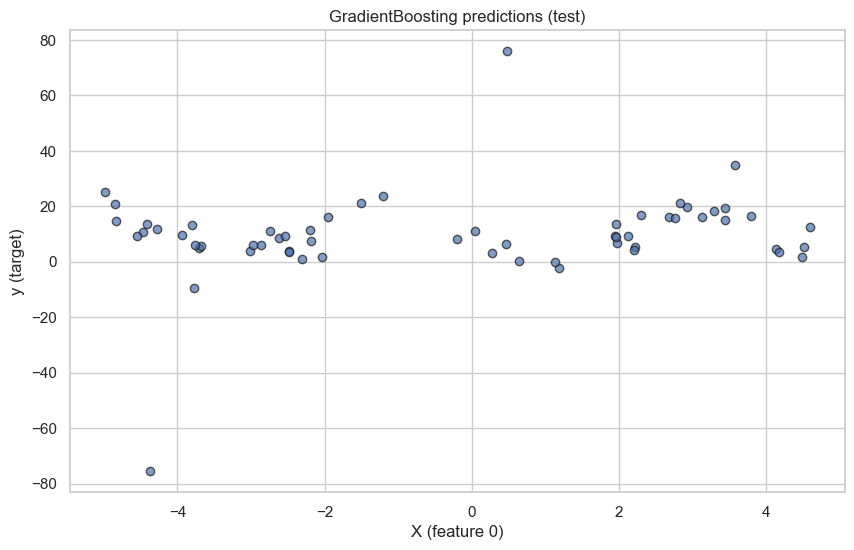

In [6]:
# Підготуємо X у потрібній формі
X_train, X_test, y_train, y_test = train_test_split(X_nonlin, y_nonlin, test_size=0.2, random_state=RANDOM_STATE)

# Побудуємо пайплайн для моделей (масштабування корисне для деяких моделей)
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=RANDOM_STATE))])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
pipe_gb = Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))])

models = {'Ridge': pipe_ridge, 'RandomForest': pipe_rf, 'GradientBoosting': pipe_gb}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f'\nModel: {name}')
    evaluate_regression_model(y_test, y_pred)
    # Якщо 1D, показати лінію/передбачення
    try:
        plot_regression_model(X_test.flatten(), y_test, weights=[pipeline.named_steps['model'].coef_[0]] 
                              if hasattr(pipeline.named_steps['model'], 'coef_') else None,
                              intercept=pipeline.named_steps['model'].intercept_ 
                              if hasattr(pipeline.named_steps['model'], 'intercept_') else None,
                              title=f'{name} predictions (test)')
    except Exception:
        # Для випадків без coef_ просто покажемо predict vs actual
        y_pred_all = pipeline.predict(X_nonlin)
        plt.scatter(y_nonlin, y_pred_all, alpha=0.6, edgecolor='k')
        plt.plot([y_nonlin.min(), y_nonlin.max()], [y_nonlin.min(), y_nonlin.max()], 'r--')
        plt.xlabel('Actual y'); plt.ylabel('Predicted y'); plt.title(f'{name} Pred vs Actual (all)')
        plt.show()


### Висновок по Частині I

- Лінійні моделі добре працюють на лінійних даних, погано — на сильнорівнівних нелінійних (sin, cos).
- Деревні ансамблі (RandomForest, GradientBoosting) краще підлаштовуються під складні нелінійні закономірності.
- Ручне титрування коефіцієнтів допомагає зрозуміти чутливість метрик до зміни параметрів.


# Частина II — Експерименти на реальному датасеті: Restaurant_revenue

Завдання:
- Завантажити датасет.
- Провести EDA (кореляція, розподіли, категоріальні змінні).
- Підготувати дані (кодування, масштабування, видалення викидів при потребі).
- Обрати top-3 методи та підібрати гіперпараметри (GridSearchCV або Randomized).
- Навчити остаточні моделі, оцінити на тесті, зробити висновки.


In [9]:
import os
csv_name = 'Restaurant_revenue (1).csv'
if os.path.exists(csv_name):
    df = pd.read_csv(csv_name)
    print('Loaded from CSV:', csv_name)
else:
    print('CSV not found — створюю DataFrame з наявних уривків (може бути неповний).')
    columns = ['Number_of_Customers','Menu_Price','Marketing_Spend','Cuisine_Type',
               'Average_Customer_Spending','Promotions','Reviews','Monthly_Revenue']
    df = pd.DataFrame(columns=columns)
print('Shape:', df.shape)
df.head(5)

Loaded from CSV: Restaurant_revenue (1).csv
Shape: (1000, 8)


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


## EDA (дослідження даних)

План:
- Перевірити типи колонок, пропуски.
- Оцінити розподіли числових змінних та категорій.
- Перевірити кореляції з таргетом.


Columns and dtypes:
Number_of_Customers            int64
Menu_Price                   float64
Marketing_Spend              float64
Cuisine_Type                  object
Average_Customer_Spending    float64
Promotions                     int64
Reviews                        int64
Monthly_Revenue              float64
dtype: object

Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Number_of_Customers,1000.0,NaN,NaN,NaN,53.271,26.364914,10.0,30.0,54.0,74.0,99.0
Menu_Price,1000.0,NaN,NaN,NaN,30.21912,11.27876,10.009501,20.396828,30.860614,39.843868,49.97414
Marketing_Spend,1000.0,NaN,NaN,NaN,9.958726,5.845586,0.003768,4.690724,10.092047,14.992436,19.994276
Cuisine_Type,1000,4,Japanese,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average_Customer_Spending,1000.0,NaN,NaN,NaN,29.477085,11.471686,10.037177,19.603041,29.251365,39.55322,49.900725
Promotions,1000.0,NaN,NaN,NaN,0.497,0.500241,0.0,0.0,0.0,1.0,1.0
Reviews,1000.0,NaN,NaN,NaN,49.837,29.226334,0.0,24.0,50.0,76.0,99.0
Monthly_Revenue,1000.0,NaN,NaN,NaN,268.724172,103.98295,-28.977809,197.103642,270.213964,343.395793,563.381332



Missing values per column:
Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64


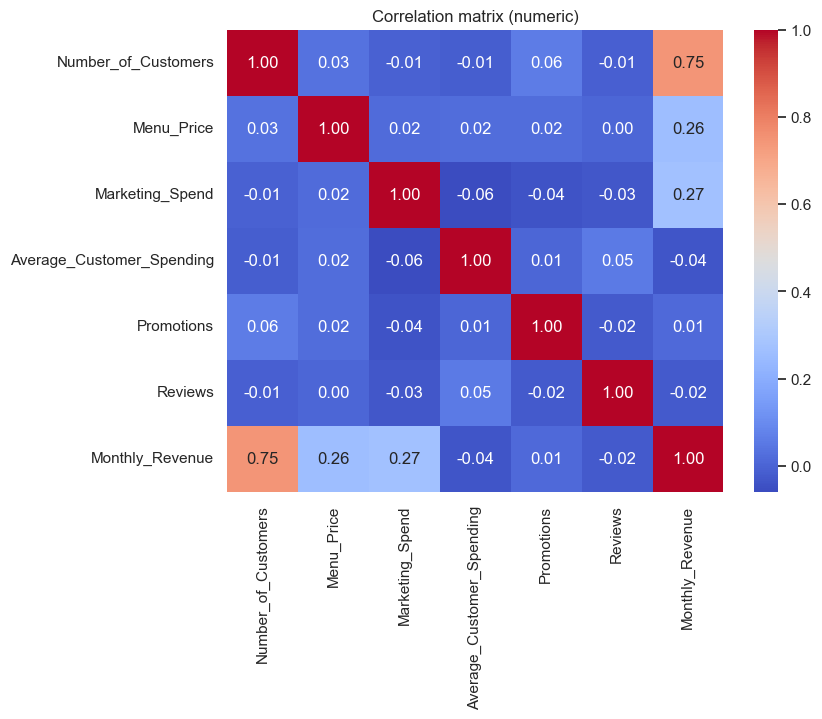

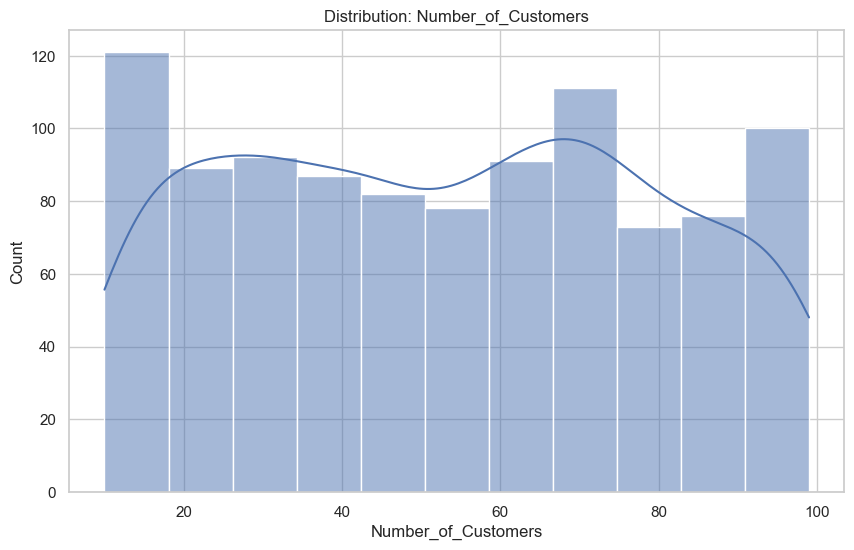

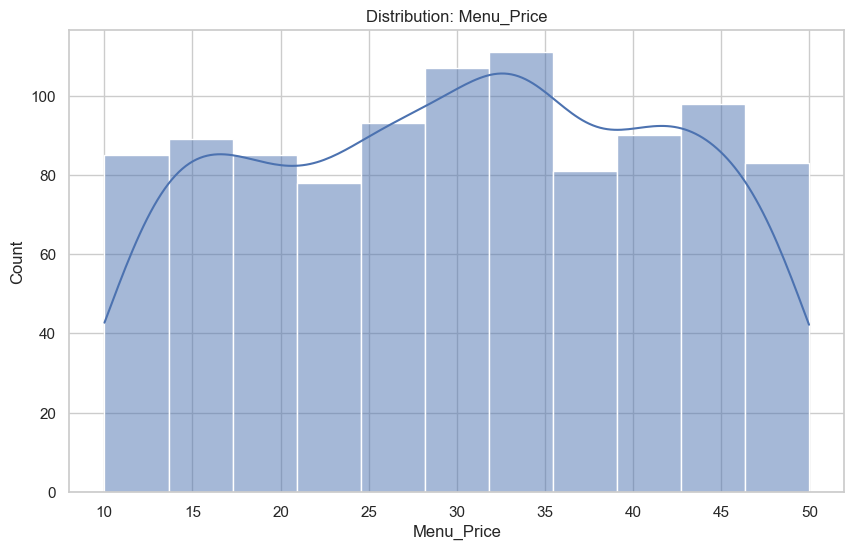

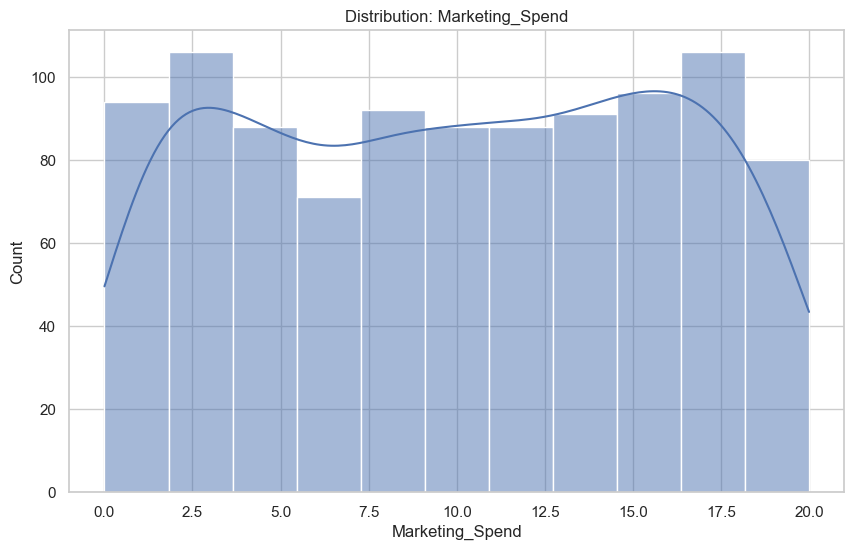

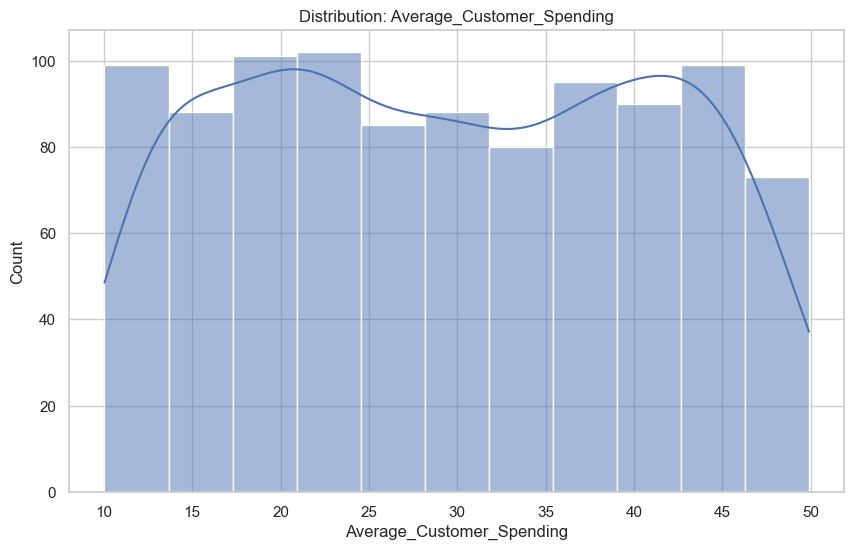

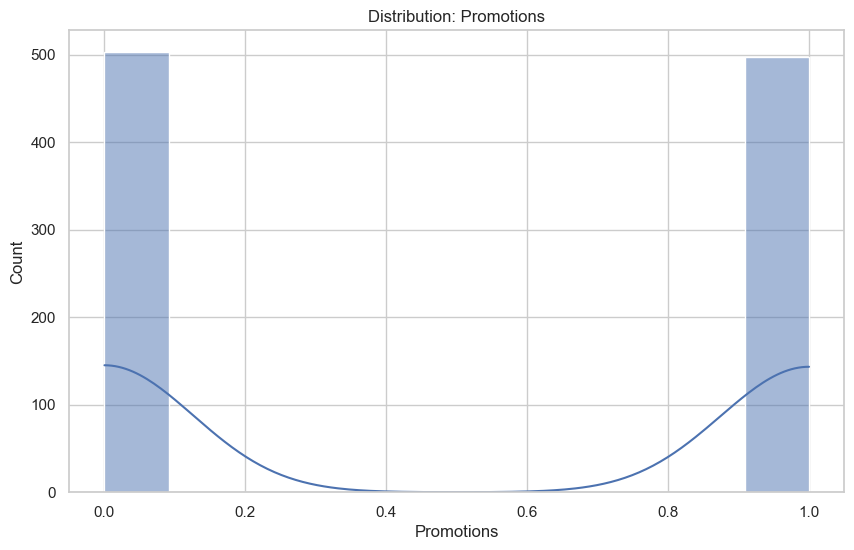

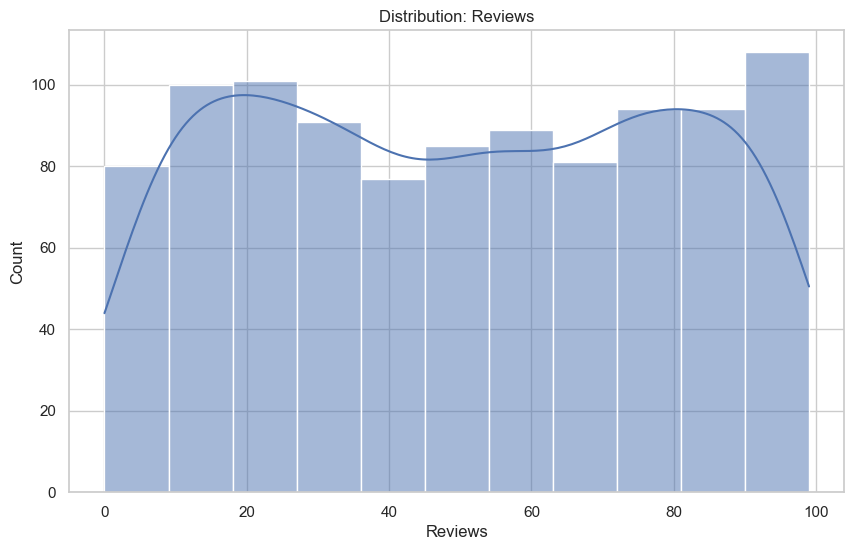

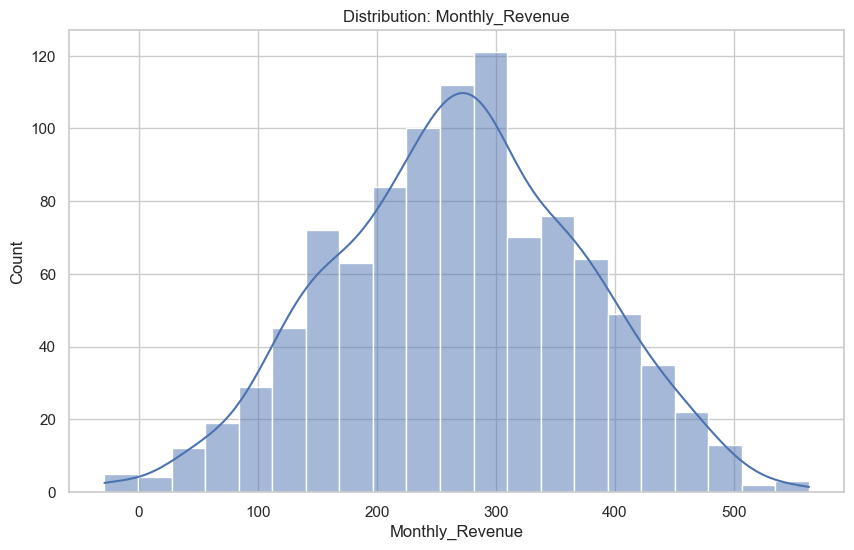

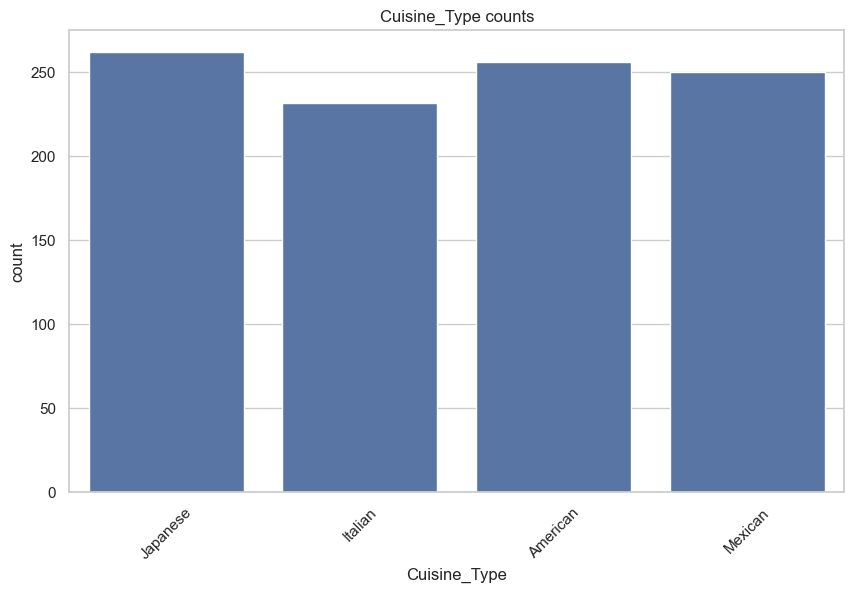

In [10]:
# Огляд
print('Columns and dtypes:')
print(df.dtypes)
print('\nSummary:')
display(df.describe(include='all').T)

# Check missing values
print('\nMissing values per column:')
print(df.isnull().sum())

# Якщо є дані, побудуємо кілька графіків
if df.shape[0] > 0:
    # Кореляційна матриця числових фіч
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation matrix (numeric)')
        plt.show()

    # Розподіли для числових колонок
    for c in num_cols:
        plt.figure()
        sns.histplot(df[c].dropna(), kde=True)
        plt.title(f'Distribution: {c}')
        plt.show()

    # Категоріальна колонка Cuisine_Type
    if 'Cuisine_Type' in df.columns:
        plt.figure()
        sns.countplot(data=df, x='Cuisine_Type')
        plt.title('Cuisine_Type counts')
        plt.xticks(rotation=45)
        plt.show()


## Підготовка даних

Кроки:
- Обробити пропуски (заповнити або видалити).
- One-hot кодування категоріальної змінної 'Cuisine_Type'.
- Масштабувати числові фічі.
- Розділити на train/test.


In [12]:
# Фіксуємо RANDOM_STATE для відтворюваності
RANDOM_STATE = 42

# Перевірка наявності колонок
expected_cols = ['Number_of_Customers','Menu_Price','Marketing_Spend','Cuisine_Type',
                 'Average_Customer_Spending','Promotions','Reviews','Monthly_Revenue']
miss = [c for c in expected_cols if c not in df.columns]

if miss:
    print('Увага — відсутні очікувані колонки:', miss)
    print('Завантаж файл повністю або відредагуй колонку names.')
else:
    # Заповнення пропусків: числові median, категоріальні mode
    df_prep = df.copy()
    for c in df_prep.select_dtypes(include=[np.number]).columns:
        df_prep[c] = df_prep[c].fillna(df_prep[c].median())
    for c in df_prep.select_dtypes(include=['object','category']).columns:
        df_prep[c] = df_prep[c].fillna(df_prep[c].mode().iloc[0])

    # Формуємо X та y
    X = df_prep.drop(columns=['Monthly_Revenue'])
    y = df_prep['Monthly_Revenue']

    # Розділення на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )
    print('Train/Test sizes:', X_train.shape, X_test.shape)

    # Пайплайн препроцесінгу: one-hot для категоріальних, scaler для чисел
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [c for c in X.columns if c not in numeric_features]

    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <- виправлено
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Train/Test sizes: (800, 7) (200, 7)


## Вибрані моделі (Top-3)

1. RandomForestRegressor  
2. GradientBoostingRegressor  
3. Ridge (як лінійна регуляризована модель)  

Ми будемо використовувати GridSearchCV для підбору ключових гіперпараметрів.


In [13]:
if not miss:
    # Пайплайни
    pipe_rf = Pipeline([('pre', preprocessor),
                        ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
    pipe_gb = Pipeline([('pre', preprocessor),
                        ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))])
    pipe_ridge = Pipeline([('pre', preprocessor),
                           ('model', Ridge())])

    # Грід параметри (не надто великі щоб швидко виконалось)
    param_grid_rf = {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 8, 15],
        'model__min_samples_split': [2, 5]
    }
    param_grid_gb = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 5]
    }
    param_grid_ridge = {
        'model__alpha': [0.1, 1.0, 10.0]
    }

    # GridSearch
    gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
    gs_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
    gs_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

    print('Fitting RandomForest GridSearch...')
    gs_rf.fit(X_train, y_train)
    print('Fitting GradientBoosting GridSearch...')
    gs_gb.fit(X_train, y_train)
    print('Fitting Ridge GridSearch...')
    gs_ridge.fit(X_train, y_train)

    # Результати
    best_models = {
        'RandomForest': gs_rf.best_estimator_,
        'GradientBoosting': gs_gb.best_estimator_,
        'Ridge': gs_ridge.best_estimator_
    }
    for name, gs in [('RandomForest', gs_rf), ('GradientBoosting', gs_gb), ('Ridge', gs_ridge)]:
        print(f'\n{name} best params:', gs.best_params_)
        print(f'{name} best CV score (neg MSE):', gs.best_score_)


Fitting RandomForest GridSearch...
Fitting GradientBoosting GridSearch...
Fitting Ridge GridSearch...

RandomForest best params: {'model__max_depth': 8, 'model__min_samples_split': 5, 'model__n_estimators': 100}
RandomForest best CV score (neg MSE): -3889.593203837604

GradientBoosting best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
GradientBoosting best CV score (neg MSE): -3772.3829191979567

Ridge best params: {'model__alpha': 1.0}
Ridge best CV score (neg MSE): -3456.3791588732392


## Оцінка кращих моделей на тестовому наборі

Порахуємо MAE, RMSE, R2 для кожної з кращих моделей та порівняємо.


In [14]:
if not miss:
    results = []
    for name, model in best_models.items():
        y_pred_test = model.predict(X_test)
        metrics = evaluate_regression_model(y_test, y_pred_test, print_results=False)
        metrics['model'] = name
        results.append(metrics)
        print(f'\nTest evaluation — {name}:')
        evaluate_regression_model(y_test, y_pred_test, print_results=True)

    # Табличний вигляд
    res_df = pd.DataFrame(results).set_index('model')
    display(res_df)



Test evaluation — RandomForest:
----- 📈 Evaluation -----
MAE: 51.1903
MSE: 4061.0974
RMSE: 63.7267
R2: 0.6282
------------------------

Test evaluation — GradientBoosting:
----- 📈 Evaluation -----
MAE: 49.8569
MSE: 3780.4364
RMSE: 61.4853
R2: 0.6539
------------------------

Test evaluation — Ridge:
----- 📈 Evaluation -----
MAE: 47.1881
MSE: 3560.5071
RMSE: 59.6700
R2: 0.6741
------------------------


,MAE,MSE,RMSE,R2
model,,,,
RandomForest,51.190335,4061.097364,63.726740,0.628230
GradientBoosting,49.856864,3780.436378,61.485253,0.653923
Ridge,47.188087,3560.507107,59.669985,0.674056


## Висновки по моделюванню доходу ресторанів

### 1. Результати оцінки на тестовій вибірці

| Модель               | MAE     | MSE       | RMSE    | R²      |
|---------------------|---------|-----------|---------|---------|
| RandomForest        | 51.19   | 4061.10   | 63.73   | 0.6282  |
| GradientBoosting    | 49.86   | 3780.44   | 61.49   | 0.6539  |
| Ridge               | 47.19   | 3560.51   | 59.67   | 0.6741  |

**Інтерпретація:**  
- Найкращі показники на тесті показує **Ridge Regression** (найнижчі MAE та RMSE, найвищий R²).  
- **GradientBoosting** також демонструє хороші результати і трохи перевершує RandomForest.  
- RandomForest трохи відстає, але теж адекватно моделює залежність.  

---

### 2. Результати GridSearch (пошук оптимальних гіперпараметрів)

| Модель               | Найкращі параметри                                    | Найкращий CV score (neg MSE) |
|---------------------|------------------------------------------------------|-----------------------------|
| RandomForest        | `n_estimators=100`, `max_depth=8`, `min_samples_split=5` | -3889.59                   |
| GradientBoosting    | `n_estimators=100`, `learning_rate=0.05`, `max_depth=3` | -3772.38                   |
| Ridge               | `alpha=1.0`                                           | -3456.38                   |

**Інтерпретація:**  
- Ridge Regression показує найменший CV MSE, тобто найкраще узагальнення на крос-валідації.  
- GradientBoosting та RandomForest мають схожі показники, але трохи гірші, що вказує на те, що лінійна регресія добре описує тренди в даних.  
- Параметри моделей були налаштовані для досягнення оптимального балансу між точністю і переобученням.

---

### 3. Загальні висновки

1. **Ridge Regression** виявилася найефективнішою моделлю для цього датасету.  
2. Складніші ансамблеві методи (RandomForest, GradientBoosting) також працюють непогано, але перевага Ridge може свідчити про відносно лінійну природу залежностей між ознаками та доходом.  
3. Подальші покращення можна отримати через додаткову інженерію ознак, взаємодії між змінними та глибший пошук гіперпараметрів для ансамблів.
